# Pre-requisites

In [1]:
# # For COLAB
# from google.colab import drive
# drive.mount('/content/gdrive')

In [2]:
# !pip install -Uq kaggle torchsummary matplotlib tensorboard
# !mkdir ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json
# ! kaggle datasets download xhlulu/140k-real-and-fake-faces

# import shutil
# shutil.unpack_archive('140k-real-and-fake-faces.zip')

In [3]:
import os
import numpy as np
import datetime
from copy import deepcopy
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torch.utils.tensorboard import SummaryWriter
import torchvision
from torchvision.utils import save_image
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchsummary import summary
torch.manual_seed(69)
%load_ext tensorboard

In [4]:
# Hyperparameters
os.makedirs("models", exist_ok=True)
CHECKPOINT_GEN = "models/wgan_generator_128.pth"
CHECKPOINT_CRITIC = "models/wgan_critic_128.pth"
LOG_FOLDER = "logs/wgan/"
device = "cuda" if torch.cuda.is_available() else "cpu"
NUM_EPOCHS = 30
BATCH_SIZE = 256
TRAIN_SUBSET_SIZE = 25000
LEARNING_RATE = 1e-4
IMAGE_SIZE = 128
CHANNELS_IMG = 3
Z_DIM = 256
FEATURES_CRITIC = 16
FEATURES_GEN = 16
CRITIC_ITERATIONS = 5
LAMBDA_GP = 10
NUM_WORKERS = 8

# Data

In [5]:
def create_dataloader(data_path, subset_size, batch_size, img_size, channels_img, class_label='real', num_workers=NUM_WORKERS):
    data_transforms = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.Normalize(
            [0.5 for _ in range(channels_img)],
            [0.5 for _ in range(channels_img)],
        ),
    ])

    dataset = datasets.ImageFolder(root=data_path, transform=data_transforms)
    class_idx = dataset.class_to_idx[class_label]
    class_indices = [i for i, label in enumerate(dataset.targets) if label == class_idx]
    # subset_indices = random.sample(class_indices, subset_size)
    subset_indices = class_indices[:subset_size]
    subset_dataset = Subset(dataset, subset_indices)
    dataloader = DataLoader(
        subset_dataset,
        batch_size=batch_size,
        shuffle=True,
        pin_memory=True,
        drop_last=True,
        num_workers=num_workers

    )
    return dataloader

97 25000


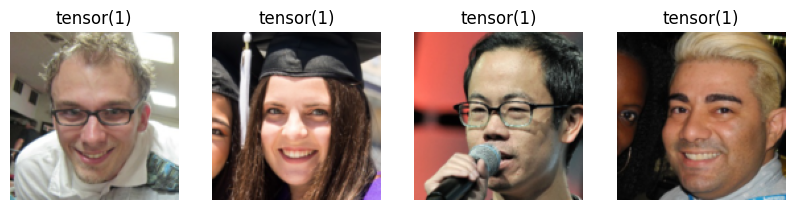

In [6]:
loader = create_dataloader("real_vs_fake/real-vs-fake/train", TRAIN_SUBSET_SIZE, BATCH_SIZE, IMAGE_SIZE, CHANNELS_IMG)
print(len(loader), len(loader.dataset))

for batch, labels in loader:
    img_count = 4
    images = batch[:img_count]
    images = (images + 1) / 2
    labels = labels[:img_count]
    plt.figure(figsize=(10, 4))
    for i in range(img_count):
      plt.subplot(1, img_count, i + 1)
      plt.imshow(images[i].permute(1,2,0))
      plt.title(labels[i])
      plt.axis("off")
    break

# Model

In [7]:
class Discriminator(nn.Module):
    def __init__(self, channels_img, features_d):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            # input: N x channels_img x 128 x 128
            nn.Conv2d(channels_img, features_d, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            # _block(in_channels, out_channels, kernel_size, stride, padding)
            self._block(features_d, features_d * 2, 4, 2, 1),
            self._block(features_d * 2, features_d * 4, 4, 2, 1),
            self._block(features_d * 4, features_d * 8, 4, 2, 1),
            self._block(features_d * 8, features_d * 16, 4, 2, 1),
            self._block(features_d * 16, features_d * 32, 4, 2, 1),
            # After all _block img output is 4x4 (Conv2d below makes into 1x1)
            nn.Conv2d(features_d * 32, 1, kernel_size=4, stride=1, padding=0),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.InstanceNorm2d(out_channels, affine=True),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        return self.disc(x)

d = Discriminator(CHANNELS_IMG, FEATURES_CRITIC)
d.cuda()
summary(d, ( CHANNELS_IMG, IMAGE_SIZE, IMAGE_SIZE))
del d
torch.cuda.empty_cache()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 128, 128]             448
         LeakyReLU-2         [-1, 16, 128, 128]               0
            Conv2d-3           [-1, 32, 64, 64]           8,192
    InstanceNorm2d-4           [-1, 32, 64, 64]              64
         LeakyReLU-5           [-1, 32, 64, 64]               0
            Conv2d-6           [-1, 64, 32, 32]          32,768
    InstanceNorm2d-7           [-1, 64, 32, 32]             128
         LeakyReLU-8           [-1, 64, 32, 32]               0
            Conv2d-9          [-1, 128, 16, 16]         131,072
   InstanceNorm2d-10          [-1, 128, 16, 16]             256
        LeakyReLU-11          [-1, 128, 16, 16]               0
           Conv2d-12            [-1, 256, 8, 8]         524,288
   InstanceNorm2d-13            [-1, 256, 8, 8]             512
        LeakyReLU-14            [-1, 25

In [8]:
class Generator(nn.Module):
    def __init__(self, channels_noise, channels_img, features_g):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            # Input: N x channels_noise x 1 x 1
            self._block(channels_noise, features_g * 32, 4, 1, 0),  # img: 4
            self._block(features_g * 32, features_g * 16, 4, 2, 1),  # img: 8
            self._block(features_g * 16, features_g * 8, 4, 2, 1),  # img: 16
            self._block(features_g * 8, features_g * 4, 4, 2, 1),  # img: 32
            self._block(features_g * 4, features_g * 2, 4, 2, 1),  # img: 64
            self._block(features_g * 2, features_g * 1, 4, 2, 1),  # img: 128
            nn.Conv2d(
                features_g * 1, channels_img, kernel_size=3, stride=1, padding=1
            ),
            # Output: N x channels_img x 128 x 128
            nn.Tanh(),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.net(x)

g = Generator(Z_DIM, CHANNELS_IMG, FEATURES_GEN)
g.cuda()
summary(g, ( Z_DIM, 1, 1))
del g
torch.cuda.empty_cache()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 512, 4, 4]       2,097,152
       BatchNorm2d-2            [-1, 512, 4, 4]           1,024
              ReLU-3            [-1, 512, 4, 4]               0
   ConvTranspose2d-4            [-1, 256, 8, 8]       2,097,152
       BatchNorm2d-5            [-1, 256, 8, 8]             512
              ReLU-6            [-1, 256, 8, 8]               0
   ConvTranspose2d-7          [-1, 128, 16, 16]         524,288
       BatchNorm2d-8          [-1, 128, 16, 16]             256
              ReLU-9          [-1, 128, 16, 16]               0
  ConvTranspose2d-10           [-1, 64, 32, 32]         131,072
      BatchNorm2d-11           [-1, 64, 32, 32]             128
             ReLU-12           [-1, 64, 32, 32]               0
  ConvTranspose2d-13           [-1, 32, 64, 64]          32,768
      BatchNorm2d-14           [-1, 32,

# Utils

In [9]:
def initialize_weights(model):
    # Initializes weights according to the DCGAN paper
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

def gradient_penalty(critic, real, fake, device="cpu"):
    BATCH_SIZE, C, H, W = real.shape
    alpha = torch.rand((BATCH_SIZE, 1, 1, 1)).repeat(1, C, H, W).to(device)
    interpolated_images = real * alpha + fake * (1 - alpha)

    # Calculate critic scores
    mixed_scores = critic(interpolated_images)

    # Take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
    return gradient_penalty


def save_checkpoint(model, optimizer, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    torch.save(checkpoint, filename)


def load_checkpoint(checkpoint_file, model, optimizer, lr):
    print("=> Loading checkpoint")
    checkpoint = torch.load(checkpoint_file, map_location="cuda")
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

    # If we don't do this then it will just have learning rate of old checkpoint
    # and it will lead to many hours of debugging \:
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr

# Training loop

In [10]:
log_folder_name = LOG_FOLDER + f"{datetime.datetime.now().strftime('%Y%m%d-%H%M%S')}/"
os.makedirs(log_folder_name, exist_ok=True)

In [11]:
# %tensorboard --logdir logs/wgan/

In [12]:
# initialize gen and disc/critic
gen = Generator(Z_DIM, CHANNELS_IMG, FEATURES_GEN).to(device)
critic = Discriminator(CHANNELS_IMG, FEATURES_CRITIC).to(device)
initialize_weights(gen)
initialize_weights(critic)

# initializate optimizer
opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.9))
opt_critic = optim.Adam(critic.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.9))

# For showing progress
fixed_noise = torch.randn(8, Z_DIM, 1, 1).to(device)

gen_losses = []
critic_losses = []


writer = SummaryWriter(log_folder_name, comment="WGAN training at image size 128")

for epoch in range(NUM_EPOCHS):
  print(f"Epoch [{epoch + 1}/{NUM_EPOCHS}]")
  gen.train()
  critic.train()

  loop = tqdm(loader, leave=True)
  for i, (real, _) in enumerate(loop):
    real = real.to(device)
    noise = torch.randn(BATCH_SIZE, Z_DIM, 1, 1).to(device)
    fake = gen(noise)

    # Train Critic: max E[critic(real)] - E[critic(fake)]
    for _ in range(CRITIC_ITERATIONS):
      critic_real = critic(real).reshape(-1)
      critic_fake = critic(fake).reshape(-1)

      gp = gradient_penalty(critic, real, fake, device=device)
      loss_critic = (-(torch.mean(critic_real) - torch.mean(critic_fake)) + LAMBDA_GP * gp)

      critic.zero_grad()
      loss_critic.backward(retain_graph=True)
      opt_critic.step()

    # Train Generator: max E[critic(gen_fake)] <-> min -E[critic(gen_fake)]
    gen_fake = critic(fake).reshape(-1)
    loss_gen = -torch.mean(gen_fake)
    gen.zero_grad()
    loss_gen.backward()
    opt_gen.step()

    loop.set_postfix(loss_critic=loss_critic.item(), loss_gen=loss_gen.item())

  gen_losses.append(loss_gen.item())
  critic_losses.append(loss_critic.item())
  writer.add_scalar("Loss/Critic", loss_critic.item(), global_step=epoch, new_style=True)
  writer.add_scalar("Loss/Gen", loss_gen.item(), global_step=epoch, new_style=True)

  gen.eval()
  critic.eval()
  with torch.no_grad():
      fake = gen(fixed_noise)
      img_grid = torchvision.utils.make_grid(fake[:8], normalize=True)
      writer.add_image("Fake", img_grid, global_step=epoch)

  save_checkpoint(gen, opt_gen, CHECKPOINT_GEN)
  save_checkpoint(critic, opt_critic, CHECKPOINT_CRITIC)

Epoch [1/30]



00%|██████████| 97/97 [01:46<00:00,  1.10s/it, loss_critic=-290, loss_gen=185]    

=> Saving checkpoint
=> Saving checkpoint
Epoch [2/30]



00%|██████████| 97/97 [01:46<00:00,  1.09s/it, loss_critic=-338, loss_gen=308]

=> Saving checkpoint
=> Saving checkpoint
Epoch [3/30]



00%|██████████| 97/97 [01:45<00:00,  1.09s/it, loss_critic=-310, loss_gen=421]

=> Saving checkpoint
=> Saving checkpoint
Epoch [4/30]



00%|██████████| 97/97 [01:45<00:00,  1.09s/it, loss_critic=-267, loss_gen=412]

=> Saving checkpoint
=> Saving checkpoint
Epoch [5/30]



00%|██████████| 97/97 [01:45<00:00,  1.09s/it, loss_critic=-217, loss_gen=402]

=> Saving checkpoint
=> Saving checkpoint
Epoch [6/30]



00%|██████████| 97/97 [01:45<00:00,  1.09s/it, loss_critic=-173, loss_gen=409]

=> Saving checkpoint
=> Saving checkpoint
Epoch [7/30]



00%|██████████| 97/97 [01:45<00:00,  1.09s/it, loss_critic=-125, loss_gen=393]

=> Saving checkpoint
=> Saving checkpoint
Epoch [8/30]



00%|██████████| 97/97 [01:45<00:00,  1.09s/it, loss_critic=-93.1, loss_gen=376]

=> Saving checkpoint
=> Saving checkpoint
Epoch [9/30]



00%|██████████| 97/97 [01:45<00:00,  1.09s/it, loss_critic=-69.1, loss_gen=353]

=> Saving checkpoint
=> Saving checkpoint
Epoch [10/30]



00%|██████████| 97/97 [01:45<00:00,  1.09s/it, loss_critic=-53.7, loss_gen=335]

=> Saving checkpoint
=> Saving checkpoint
Epoch [11/30]



00%|██████████| 97/97 [01:45<00:00,  1.09s/it, loss_critic=-46.6, loss_gen=313]

=> Saving checkpoint
=> Saving checkpoint
Epoch [12/30]



00%|██████████| 97/97 [01:45<00:00,  1.09s/it, loss_critic=-44.5, loss_gen=302]

=> Saving checkpoint
=> Saving checkpoint
Epoch [13/30]



00%|██████████| 97/97 [01:45<00:00,  1.09s/it, loss_critic=-43.8, loss_gen=281]

=> Saving checkpoint
=> Saving checkpoint
Epoch [14/30]



00%|██████████| 97/97 [01:45<00:00,  1.09s/it, loss_critic=-40.9, loss_gen=280]

=> Saving checkpoint
=> Saving checkpoint
Epoch [15/30]



00%|██████████| 97/97 [01:45<00:00,  1.09s/it, loss_critic=-52.9, loss_gen=240]

=> Saving checkpoint
=> Saving checkpoint
Epoch [16/30]



00%|██████████| 97/97 [01:45<00:00,  1.09s/it, loss_critic=-45.9, loss_gen=248]

=> Saving checkpoint
=> Saving checkpoint
Epoch [17/30]



00%|██████████| 97/97 [01:45<00:00,  1.09s/it, loss_critic=-45.4, loss_gen=228]

=> Saving checkpoint
=> Saving checkpoint
Epoch [18/30]



00%|██████████| 97/97 [01:45<00:00,  1.09s/it, loss_critic=-44.3, loss_gen=256]

=> Saving checkpoint
=> Saving checkpoint
Epoch [19/30]



00%|██████████| 97/97 [01:45<00:00,  1.09s/it, loss_critic=-41.4, loss_gen=239]

=> Saving checkpoint
=> Saving checkpoint
Epoch [20/30]



00%|██████████| 97/97 [01:45<00:00,  1.09s/it, loss_critic=-37.6, loss_gen=220]

=> Saving checkpoint
=> Saving checkpoint
Epoch [21/30]



00%|██████████| 97/97 [01:45<00:00,  1.09s/it, loss_critic=-38.5, loss_gen=233]

=> Saving checkpoint
=> Saving checkpoint
Epoch [22/30]



00%|██████████| 97/97 [01:45<00:00,  1.09s/it, loss_critic=-32.6, loss_gen=260]

=> Saving checkpoint
=> Saving checkpoint
Epoch [23/30]



00%|██████████| 97/97 [01:45<00:00,  1.09s/it, loss_critic=-32.3, loss_gen=236]

=> Saving checkpoint
=> Saving checkpoint
Epoch [24/30]



00%|██████████| 97/97 [01:45<00:00,  1.09s/it, loss_critic=-38.1, loss_gen=285]

=> Saving checkpoint
=> Saving checkpoint
Epoch [25/30]



00%|██████████| 97/97 [01:46<00:00,  1.09s/it, loss_critic=-34.6, loss_gen=251]

=> Saving checkpoint
=> Saving checkpoint
Epoch [26/30]



00%|██████████| 97/97 [01:45<00:00,  1.09s/it, loss_critic=-36.6, loss_gen=254]

=> Saving checkpoint
=> Saving checkpoint
Epoch [27/30]



00%|██████████| 97/97 [01:45<00:00,  1.09s/it, loss_critic=-33.8, loss_gen=270]

=> Saving checkpoint
=> Saving checkpoint
Epoch [28/30]



00%|██████████| 97/97 [01:46<00:00,  1.09s/it, loss_critic=-37, loss_gen=268]  

=> Saving checkpoint
=> Saving checkpoint
Epoch [29/30]



00%|██████████| 97/97 [01:45<00:00,  1.09s/it, loss_critic=-31.1, loss_gen=226]

=> Saving checkpoint
=> Saving checkpoint
Epoch [30/30]



00%|██████████| 97/97 [01:45<00:00,  1.09s/it, loss_critic=-31.2, loss_gen=236]

=> Saving checkpoint
=> Saving checkpoint


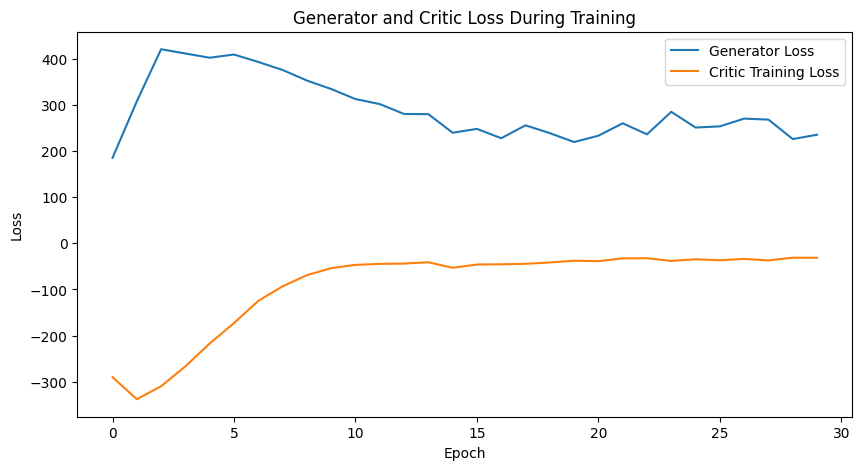

In [13]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(gen_losses, label="Generator Loss")
plt.plot(critic_losses, label="Critic Training Loss")
plt.title("Generator and Critic Loss During Training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig(log_folder_name + "wgan_loss_curve.png")  # Save the loss plot
plt.show()

# Inferencing

In [14]:
# gen = Generator(Z_DIM, CHANNELS_IMG, FEATURES_GEN).to(device)
# opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.9))
# load_checkpoint(CHECKPOINT_GEN, gen, opt_gen, LEARNING_RATE,)
# gen.eval()

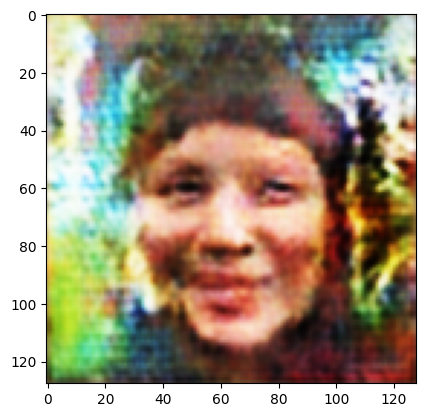

In [100]:
imgs = gen(torch.randn(1, Z_DIM, 1, 1).to(device))
imgs = (imgs * 0.5) + 0.5
plt.imshow(imgs[0].cpu().detach().permute(1, 2, 0))